In [1]:
from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

In [2]:
from openmmtools.testsystems import AlanineDipeptideImplicit

In [3]:
testsystem = AlanineDipeptideImplicit()
len(testsystem.positions)

22

In [4]:
testsystem.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x116e7ef00> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x116e7ef90> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x116e77030> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x116e77060> >,
 <simtk.openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x116e77090> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x116e770c0> >]

In [5]:
gbsa_force = testsystem.system.getForce(4)
gbsa_force

<simtk.openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x116e700c0> >

In [6]:
from autograd import numpy as np
from autograd import grad


def step(x):
    return 1.0 * (x > 0)

# first, implement with for loops: later, vectorize
def compute_OBC_energy_reference(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric
                     ):
    N = len(radii)
    assert((len(charges) == N) and (distance_matrix.shape == (N,N)))
    
    # first, compute this intermediate value that depends on pairs
    I = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            
            if i != j:
                r = distance_matrix[i, j]
                or1 = radii[i] - offset
                or2 = radii[j] - offset
                sr2 = scales[j] * or2
                
                D = step(r - sr2) * (r - sr2) + (1 - step(r - sr2)) * (sr2 - r)
                L = step(or1 - D) * or1 + (1 - step(or1 - D)) * D
                C = 2 * ((1 / or1) - (1 / L)) * step(sr2 - r - or1)
                U = r + sr2
                I[i, j] = step(r + sr2 - or1) * 0.5 * ((1 / L) - (1 / U) + 0.25 * (1 / (U**2) - 1 / (L**2)) * (r - sr2 * sr2 / r) + 0.5 * np.log(L / U) / r + C)
    I = np.sum(I, axis=1)
    
    # okay, next compute born radii
    B = np.zeros(N)
    for i in range(N):
        offset_radius = radii[i] - offset
        psi = I[i] * offset_radius
        B[i] = 1 / (1 / offset_radius - np.tanh(1 * psi - 0.8 * psi**2 + 4.85 * psi**3) / radii[i])
    
    # finally, compute two energy terms
    E = 0
    
    # single particle
    for i in range(N):
        E += surface_tension * (radii[i] + 0.14)**2 * (radii[i] / B[i])**6 - 0.5 * screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * charges[i]**2 / B[i]
    # particle pair
    for i in range(N):
        for j in range(i):
            r = distance_matrix[i,j]
            f = np.sqrt(r**2 + B[i] * B[j] * np.exp(-r**2 / (4*B[i]*B[j])))
            E += -screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * charges[i] * charges[j] / f
    return E

In [7]:
N = 22
distance_matrix = np.random.rand(N, N) + 1
radii = np.random.rand(N) + 1
scales = np.random.rand(N) + 1
charges = np.random.randn(N)
offset = 0.009
screening = 138.935456
surface_tension = 28.3919551
solvent_dielectric = 70.0
solute_dielectric = 1.0

In [8]:
compute_OBC_energy_reference(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

-1.345791897185671

In [9]:
def objective(radii):
    return compute_OBC_energy_reference(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

In [10]:
# grad(objective)(radii) # gives a value error...

In [11]:
def compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric
                     ):
    N = len(radii)
    assert((len(charges) == N) and (distance_matrix.shape == (N,N)))
    
    # first, compute this intermediate value that depends on pairs
    r = distance_matrix
    or1 = radii.reshape((N, 1)) - offset
    or2 = radii.reshape((1, N)) - offset
    sr2 = scales.reshape((1, N)) * or2
    D = step(r - sr2) * (r - sr2) + (1 - step(r - sr2)) * (sr2 - r)
    L = step(or1 - D) * or1 + (1 - step(or1 - D)) * D
    C = 2 * ((1 / or1) - (1 / L)) * step(sr2 - r - or1)
    U = r + sr2
    I = step(r + sr2 - or1) * 0.5 * ((1 / L) - (1 / U) + 0.25 * (1 / (U**2) - 1 / (L**2)) * (r - sr2 * sr2 / r) + 0.5 * np.log(L / U) / r + C)
    
    I -= np.diag(np.diag(I))
    I = 0.5 * np.sum(I, axis=1)
    
    # okay, next compute born radii
    offset_radius = radii - offset
    psi = I * offset_radius
    B = 1 / (1 / offset_radius - np.tanh(1 * psi - 0.8 * psi**2 + 4.85 * psi**3) / radii)
    
    # finally, compute two energy terms
    E = 0
    
    # single particle
    E += np.sum(surface_tension * (radii + 0.14)**2 * (radii / B)**6 - 0.5 * screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * charges**2 / B)
    
    # particle pair
    f = np.sqrt(r**2 + np.outer(B, B) * np.exp(-r**2 / (4*np.outer(B, B))))
    X = - screening * ((1 / solute_dielectric) - (1 / solvent_dielectric)) * np.outer(charges, charges) / f
    E += np.sum(np.triu(X, k=1))
    return E

In [12]:
%%time
compute_OBC_energy_reference(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

CPU times: user 12 ms, sys: 396 µs, total: 12.4 ms
Wall time: 12.1 ms


-1.345791897185671

In [13]:
%%time
compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

CPU times: user 458 µs, sys: 78 µs, total: 536 µs
Wall time: 505 µs


-1.3458499346803987

In [14]:
# ^ interesting that it's not quite the same value -- prety close, but different after 5 decimal places

In [15]:
def objective(radii):
    return compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges, offset, screening, surface_tension, solvent_dielectric, solute_dielectric)

In [16]:
%%time
grad(objective)(radii)

CPU times: user 4.01 ms, sys: 216 µs, total: 4.23 ms
Wall time: 4.17 ms


array([-1.03738647,  0.24295667,  0.07235081,  0.86086088,  0.53388151,
       -0.20288838,  0.05851524, -0.80319351,  0.07611098, -0.06452333,
        0.15964325,  1.27944591, -0.70519951,  0.5173619 , -0.59202156,
       -0.7985833 , -0.32982831, -0.01192637,  1.46675623,  0.32268517,
       -0.22618574,  0.69895135])

In [17]:
len(radii)

22

In [18]:
implicit_sim = app.Simulation(testsystem.topology,
                     testsystem.system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('CPU')
                    )
implicit_sim.context.setPositions(testsystem.positions)
implicit_sim.step(1)

In [19]:
%%time
implicit_sim.step(100)

CPU times: user 145 ms, sys: 259 ms, total: 404 ms
Wall time: 177 ms


In [20]:
from tqdm import tqdm
implicit_traj = []
for _ in tqdm(range(25)):
    implicit_sim.step(1000)
    implicit_traj.append(implicit_sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 25/25 [00:45<00:00,  1.87s/it]


In [21]:
vacuum_testsystem = AlanineDipeptideImplicit()
vacuum_testsystem.system.removeForce(4)
vacuum_testsystem.system.getForces()

[<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x1173ccc90> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x1173b9990> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x1173b9150> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x1173b92d0> >,
 <simtk.openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x1173b9630> >]

In [22]:
vacuum_sim = app.Simulation(vacuum_testsystem.topology,
                     vacuum_testsystem.system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('Reference')
                    )
vacuum_sim.context.setPositions(vacuum_testsystem.positions)
vacuum_sim.step(1)

In [23]:
vacuum_sim.step(100)

In [24]:
from tqdm import tqdm
vacuum_traj = []

for _ in tqdm(range(25)):
    vacuum_sim.step(1000)
    vacuum_traj.append(vacuum_sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 25/25 [00:02<00:00, 10.12it/s]


In [25]:
x = vacuum_traj + implicit_traj

In [26]:
from openmmtools.constants import kB
kT = kB * 298 * unit.kelvin

In [27]:
u_kn = np.zeros((2, len(x)))

for i in range(len(x)):
    vacuum_sim.context.setPositions(x[i])
    implicit_sim.context.setPositions(x[i])
    
    u_kn[0, i] = vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy() / kT
    u_kn[1, i] = implicit_sim.context.getState(getEnergy=True).getPotentialEnergy() / kT

In [28]:
import pymbar
mbar = pymbar.MBAR(u_kn, [len(vacuum_traj)]*2)

In [29]:
mbar.f_k

array([  0.        , -22.70127807])

In [30]:
[m[0,1] for m in mbar.getFreeEnergyDifferences()[:2]]

[-22.701278073540955, 0.28126865465612694]

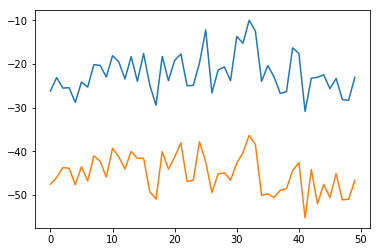

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(u_kn[0])
plt.plot(u_kn[1])

In [32]:
N = len(vacuum_traj)

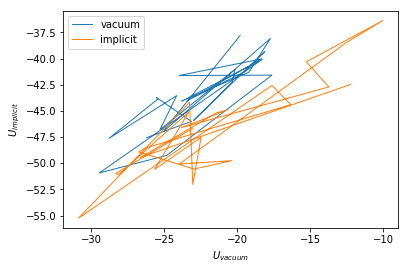

In [33]:
plt.plot(u_kn[0][:N], u_kn[1][:N], linewidth=1, label='vacuum')
plt.plot(u_kn[0][N:], u_kn[1][N:], linewidth=1, label='implicit')
plt.xlabel(r'$U_{vacuum}$')
plt.ylabel(r'$U_{implicit}$')
plt.legend(loc='best')

In [34]:
vacuum_xyz = np.array([frame.value_in_unit(unit.nanometer) for frame in vacuum_traj])
implicit_xyz = np.array([frame.value_in_unit(unit.nanometer) for frame in implicit_traj])

In [35]:
import mdtraj as md
md_top = md.Topology().from_openmm(testsystem.topology)
vacuum_md_traj = md.Trajectory(vacuum_xyz, md_top)
implicit_md_traj = md.Trajectory(implicit_xyz, md_top)

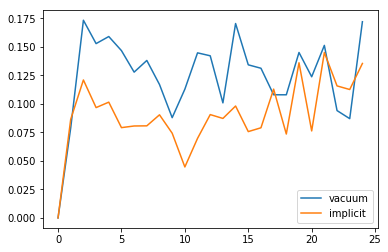

In [36]:
plt.plot(md.rmsd(vacuum_md_traj, vacuum_md_traj), label='vacuum')
plt.plot(md.rmsd(implicit_md_traj, implicit_md_traj), label='implicit')
plt.legend(loc='best')

In [37]:
vacuum_Us = []
for i in range(len(x)):
    vacuum_sim.context.setPositions(x[i])
    vacuum_Us.append(vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy())

In [38]:
implicit_only = AlanineDipeptideImplicit()
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(0)
implicit_only.system.removeForce(1)
implicit_only.system.getForces()

[<simtk.openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x11a621090> >]

In [39]:
implicit_only_sim = app.Simulation(testsystem.topology,
                     implicit_only.system,
                     mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                     platform=mm.Platform.getPlatformByName('CPU')
                    )
implicit_only_sim.context.setPositions(testsystem.positions)

In [40]:
implicit_only_Us = []
for i in range(len(x)):
    implicit_only_sim.context.setPositions(x[i])
    implicit_only_Us.append(implicit_only_sim.context.getState(getEnergy=True).getPotentialEnergy())

In [41]:
implicit_only_Us[0]

Quantity(value=-52.827789068222046, unit=kilojoule/mole)

In [42]:
combined_us = np.array([(implicit_only_Us[i] + vacuum_Us[i]) / kT for i in range(len(x))])
np.linalg.norm(combined_us - u_kn[1])

8.537092740963053e-05

In [43]:
from scipy.spatial.distance import pdist, squareform

In [44]:
def precompute_distance_matrices(x):
    return [squareform(pdist(snapshot)) + np.eye(len(snapshot)) for snapshot in x]

In [45]:
%%time
distance_matrices = precompute_distance_matrices(x)

CPU times: user 4.98 ms, sys: 2.55 ms, total: 7.53 ms
Wall time: 5.3 ms


In [46]:
radii = []
charges = []
scales = []
for i in range(gbsa_force.getNumPerParticleParameters()):
    print(gbsa_force.getPerParticleParameterName(i))

for i in range(gbsa_force.getNumParticles()):
    charge, o_r, s_r = gbsa_force.getParticleParameters(i)
    radii.append(o_r)
    charges.append(charge)
    scales.append(s_r / o_r)

charge
or
sr


In [47]:
gbsa_force.getParticleParameters(0)

(0.1123, 0.111, 0.09435)

In [48]:
radii = np.array(radii)
charges = np.array(charges)
scales = np.array(scales)
radii, charges, scales

(array([0.111, 0.161, 0.111, 0.111, 0.161, 0.141, 0.146, 0.121, 0.161,
        0.111, 0.161, 0.111, 0.111, 0.111, 0.161, 0.141, 0.146, 0.121,
        0.161, 0.111, 0.111, 0.111]),
 array([ 0.1123, -0.3662,  0.1123,  0.1123,  0.5972, -0.5679, -0.4157,
         0.2719,  0.0337,  0.0823, -0.1825,  0.0603,  0.0603,  0.0603,
         0.5973, -0.5679, -0.4157,  0.2719, -0.149 ,  0.0976,  0.0976,
         0.0976]),
 array([0.85, 0.72, 0.85, 0.85, 0.72, 0.85, 0.79, 0.85, 0.72, 0.85, 0.72,
        0.85, 0.85, 0.85, 0.72, 0.85, 0.79, 0.85, 0.72, 0.85, 0.85, 0.85]))

In [49]:
offset = 0.009
screening = 138.935456
surface_tension = 28.3919551
solvent_dielectric = 70.0
solute_dielectric = 1.0

In [50]:
distance_matrices[0].shape

(22, 22)

In [51]:
compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric)

-862.0555224902309

In [52]:
autograd_energies = [compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric) for distance_matrix in distance_matrices]

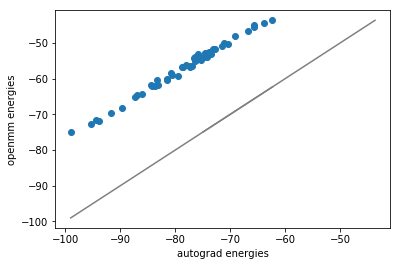

In [53]:
openmm_energies = [v.value_in_unit(unit.kilojoule_per_mole) for v in implicit_only_Us]
plt.scatter(autograd_energies, openmm_energies)
plt.xlabel('autograd energies')
plt.ylabel('openmm energies')
plt.plot(sorted(autograd_energies), sorted(autograd_energies), color='grey')
plt.plot(sorted(openmm_energies), sorted(openmm_energies), color='grey')

In [55]:
# okay can probably ignore that, and hope that I'm just missing some additive factor?

In [54]:
from autograd.scipy.misc import logsumexp

def compute_perturbed_free_energies(mbar, u_ln):
    
    states_with_samples = (mbar.N_k > 0)
    log_q_k = mbar.f_k[states_with_samples] - mbar.u_kn[states_with_samples].T
    log_denominator_n = logsumexp(log_q_k, b=mbar.N_k[states_with_samples], axis=1)
    
    return logsumexp(-u_ln[:len(u_ln)] - log_denominator_n, axis=1)

In [55]:
N = 22

In [56]:
def unpack_theta(theta):
    assert(len(theta) == ((2 * N) + 3))
    radii = theta[:N]
    scales = theta[N:2*N]
    offset, screening, surface_tension = theta[2*N:]
    return radii, scales, offset, screening, surface_tension

def pack_theta(radii, scales, offset, screening, surface_tension):
    theta = np.zeros(((2 * N) + 3))
    theta[:N] = radii
    theta[N:2*N] = scales
    theta[2*N:] = (offset, screening, surface_tension)
    return theta

In [57]:
theta = pack_theta(radii, scales, offset, screening, surface_tension)
theta

array([1.11000000e-01, 1.61000000e-01, 1.11000000e-01, 1.11000000e-01,
       1.61000000e-01, 1.41000000e-01, 1.46000000e-01, 1.21000000e-01,
       1.61000000e-01, 1.11000000e-01, 1.61000000e-01, 1.11000000e-01,
       1.11000000e-01, 1.11000000e-01, 1.61000000e-01, 1.41000000e-01,
       1.46000000e-01, 1.21000000e-01, 1.61000000e-01, 1.11000000e-01,
       1.11000000e-01, 1.11000000e-01, 8.50000000e-01, 7.20000000e-01,
       8.50000000e-01, 8.50000000e-01, 7.20000000e-01, 8.50000000e-01,
       7.90000000e-01, 8.50000000e-01, 7.20000000e-01, 8.50000000e-01,
       7.20000000e-01, 8.50000000e-01, 8.50000000e-01, 8.50000000e-01,
       7.20000000e-01, 8.50000000e-01, 7.90000000e-01, 8.50000000e-01,
       7.20000000e-01, 8.50000000e-01, 8.50000000e-01, 8.50000000e-01,
       9.00000000e-03, 1.38935456e+02, 2.83919551e+01])

In [58]:
radii.shape, N

((22,), 22)

In [59]:
def compute_u_ln(theta):
    radii, scales, offset, screening, surface_tension = unpack_theta(theta)
    
    
    u_new = np.array([compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                      offset, screening, surface_tension,
                      solvent_dielectric, solute_dielectric)
                      for distance_matrix in distance_matrices]).reshape((1, len(distance_matrices)))
    u_ln = np.vstack([u_kn, u_new])
    return u_ln

In [60]:
u_ln = compute_u_ln(theta)

In [61]:
u_ln.shape

(3, 50)

In [62]:
f_k = compute_perturbed_free_energies(mbar, u_ln)

In [63]:
f_k[:2]

array([-1.77635684e-15,  2.27012781e+01])

In [64]:
f_k[0]

-1.7763568394002505e-15

In [65]:
f_k[-1]

76.02698432409282

In [66]:
f_k

array([-1.77635684e-15,  2.27012781e+01,  7.60269843e+01])

In [123]:
def loss(theta):
    u_ln = compute_u_ln(theta)
    f_k = compute_perturbed_free_energies(mbar, u_ln)
    if np.sum(np.isnan(f_k)) > 0:
        return np.inf
    else:
        return (f_k[1] - f_k[2])**2

In [124]:
loss(theta)

2843.6309471201466

In [125]:
%%time
grad(loss)(theta)

CPU times: user 301 ms, sys: 9.13 ms, total: 310 ms
Wall time: 305 ms


array([-2.48781320e+03, -4.50694820e+03, -3.77929967e+03, -3.80264242e+03,
       -8.25950335e+03, -7.62114594e+04, -7.43136590e+03, -1.84744924e+04,
       -4.69632693e+03, -6.97639501e+03, -7.70022561e+02, -9.02989317e+02,
       -1.03655411e+03, -5.42515093e+02, -1.31200250e+04, -7.86081289e+04,
       -1.20132989e+04, -2.14319027e+04, -5.04211128e+03, -2.30207689e+03,
       -2.85245429e+03, -2.26270509e+03, -2.13751030e+01, -1.47420761e+02,
        6.55236460e+01,  3.94086988e+01, -5.58105608e+02,  8.73312644e+01,
       -4.64035603e+02,  1.21007262e+02, -4.08763677e+02, -5.89618644e+01,
        2.84835335e+02,  7.19308117e+01,  1.08205835e+02,  1.16945013e+02,
       -7.58576827e+02,  1.48883665e+01, -3.61132044e+02, -4.83308479e+00,
        5.70105672e-01,  4.01163621e+00,  6.75282266e+01,  4.38405467e+00,
        6.05722097e+04,  1.05466517e+02, -1.44480895e+02])

In [126]:
g = grad(loss)(theta)

In [127]:
np.linalg.norm(g)

130657.10041115135

In [128]:
from tqdm import tqdm
def langevin(x, v, force, n_steps=100, stepsize=0.01, collision_rate=1e-5, reduced_temperature=1):
    
    x = np.array(x)
    v = np.array(v)
    traj = [np.array(x)]
    
    energies = [loss(x)]
    
    a = np.exp(- collision_rate * stepsize)
    b = np.sqrt(1 - np.exp(-2 * collision_rate * stepsize))
    
    F = force(x)
    #print(F)
    
    trange = tqdm(range(n_steps))
    for _ in trange:
        # v
        v += (stepsize * 0.5) * F
        # r
        x += (stepsize * 0.5) * v
        # o
        v = (a * v) + (b * np.random.randn(*x.shape) * reduced_temperature)
        # r
        x += (stepsize * 0.5) * v
        
        F = force(x)
        # v
        v += (stepsize * 0.5) * F
        
        energy = loss(x)
        trange.set_postfix({'energy': energy})
        #print(energy)
        
        if (np.sum(np.isfinite(x)) != len(x)) or (not np.isfinite(energy)):
            print("Numerical instability encountered!")
            return np.array(traj), np.array(energies)
        
        traj.append(np.array(x))
        energies.append(energy)

    return np.array(traj), np.array(energies)

In [129]:
def force(x):
    return -grad(loss)(x)

In [132]:
from scipy.optimize import minimize
result = minimize(loss, theta,
                  jac=grad(loss),
                  tol=0.1,
                  options={'disp': True, 'maxiter': 10})

/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  r

         Current function value: 0.022122
         Iterations: 3
         Function evaluations: 41
         Gradient evaluations: 20


/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


In [133]:
np.linalg.norm(force(result.x)), np.linalg.norm(force(theta))

(675.035228650683, 130657.10041115135)

In [136]:
np.random.seed(0)
x = result.x
v = np.random.randn(len(theta))
stepsize = 0.001
collision_rate = 1.0 / stepsize
traj, energies = langevin(x, v, force, n_steps=1000, stepsize=stepsize, collision_rate=collision_rate, reduced_temperature=0.1)

100%|██████████| 1000/1000 [04:26<00:00,  3.65it/s, energy=0.00589]


In [137]:
traj.shape

(1001, 47)

In [138]:
loss(theta)

2843.6309471201466

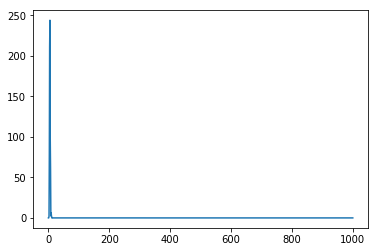

In [139]:
plt.plot(energies)

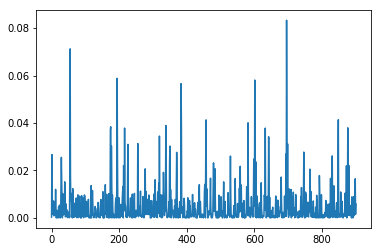

In [140]:
plt.plot(energies[100:])

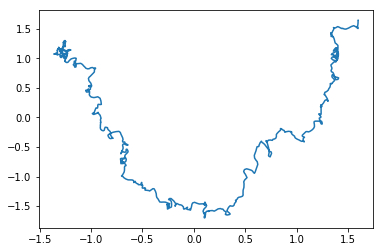

In [141]:
from msmbuilder.decomposition import tICA

tica = tICA()
y = tica.fit_transform([traj[100:]])[0]

plt.plot(y[:,0], y[:,1])

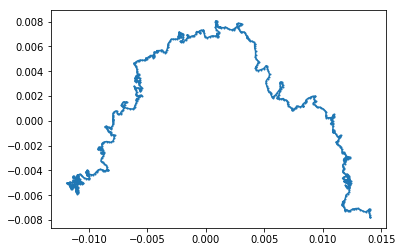

In [142]:
from sklearn.decomposition import PCA

pca = PCA()
y = pca.fit_transform(traj[100:])
plt.plot(y[:,0], y[:,1])
plt.scatter(y[:,0], y[:,1], s=1)

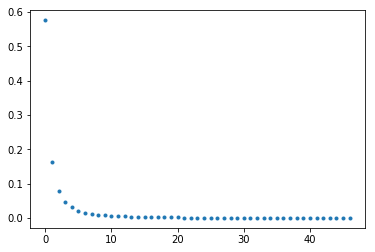

In [143]:
plt.plot(pca.explained_variance_ratio_, '.')

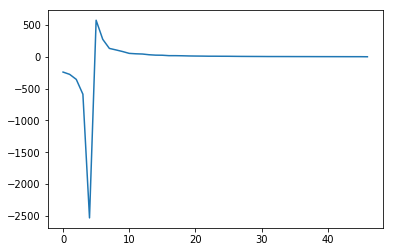

In [144]:
plt.plot(tica.timescales_)

In [145]:
np.linalg.norm(result.x - theta)

0.1955339866578238

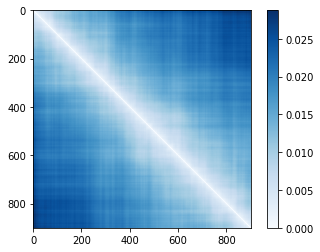

In [146]:
plt.imshow(squareform(pdist(traj[100:])), cmap='Blues')
plt.colorbar()

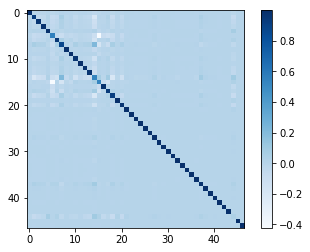

In [147]:
plt.imshow(result.hess_inv, cmap='Blues')
plt.colorbar()

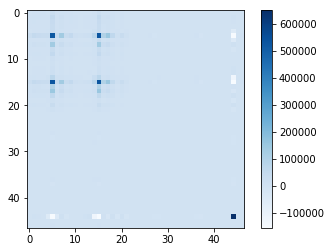

In [148]:
plt.imshow(np.linalg.pinv(result.hess_inv), cmap='Blues')
plt.colorbar()

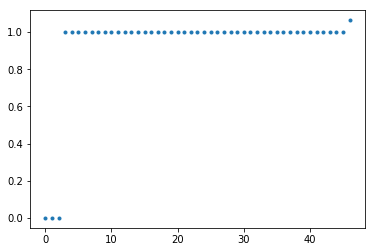

In [149]:
plt.plot(np.linalg.eigvalsh(result.hess_inv), '.')

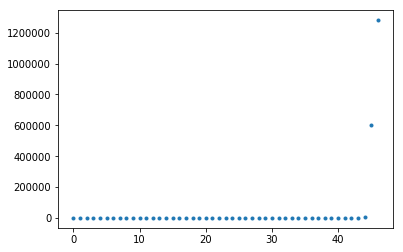

In [150]:
plt.plot(np.linalg.eigvalsh(np.linalg.inv(result.hess_inv)), '.')

In [151]:
np.linalg.cond(result.hess_inv)

1363011.4903941783

In [152]:
samples = traj[100:]

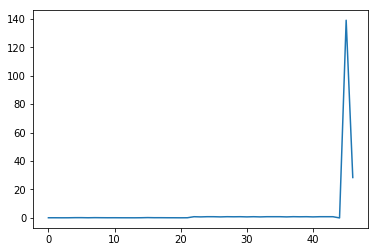

In [153]:
plt.plot(samples.mean(0))

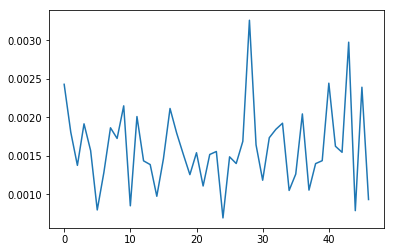

In [154]:
plt.plot(samples.std(0))

In [155]:
cov = pca.get_covariance()

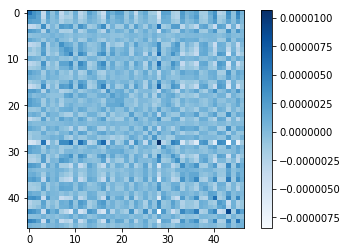

In [156]:
plt.imshow(cov, cmap='Blues')
plt.colorbar()

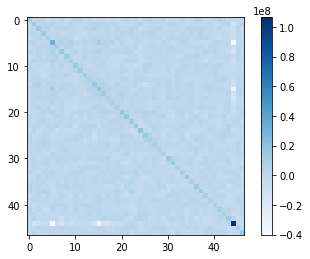

In [157]:
plt.imshow(np.linalg.pinv(cov), cmap='Blues')
plt.colorbar()

In [158]:
np.linalg.cond(cov)

11453.464620169214